# Part 2 
## 2.1 File Reading and Fitness

 1. Read in cities into a list - [2]
 2. Read routes into a graph - [3]
 3. Get the distance between two nodes - [3]
 4. Create a random solution - [5]
 5. Calculate total distance of random solution - [5]

## 2.2 Algorithm

 1. Swap mutation - [6]
 2. Ruin and recreate - [6]
 3. Hill Climber - [7]

## 2.3 Visualization

 1. Algorithm validation (repeat 30 times) - [12]
 2. Calculating the min, avg and max fitness - [13]
 3. Graphs - [15, 16]



## Packages needed:
- pandas
- sklearn
- numpy
- matplotlib
- tqdm

#### note: tqdm is only for the tracking of loop progress, if you don't want to install it, it can be removed and the code will function correctly without it. Just keep the range() inside

In [1]:
import numpy as np
import random
import random
import time
import math
import tqdm
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")


CITIES_FILE = "./cities.txt"
DISTANCES_FILE = "./distances.csv"



In [2]:
# Load the cities in to an array
cities_file = open(CITIES_FILE, "r")
cities = [] # List that will hold the cities
for line in cities_file:
    city = line.strip('\n')
    cities.append(city)
    
cities_file.close()

In [3]:
# Storing the cities in a graph for speedy traversal
# Testing showed
class Graph:
    def __init__(self, distances_file_name: str):
        self.graph = {}
        distances_file = open(distances_file_name, "r")
        i = 0
        for line in distances_file:
            line = line.strip('\n').split(',')
            distances = []
            for j in range( len(line) ):
                distances.append((cities[j], float(line[j]) ))
            self.graph[ cities[i] ] = distances
            i += 1
        distances_file.close()

    def print(self):
        for i in self.graph:
            print(i, ':', self.graph[i])

    def get_distance(self, start: str, end: str):
        for edge in self.graph[start]:
            if edge[0] == end:
                return edge[1]
        # if we get here we haven't returned anything
        # this won't be in a try/catch inside the main function as if this ever gets thrown, something has gone critically wrong
        raise Exception("Route not found")
    
        
g = Graph(DISTANCES_FILE)


# Speed test function below to test how fast a single graph look up is
# Optimisations took it to 2 million single city look ups per second!
# for i in tqdm.tqdm( range(10000000) ):
#     g.get_distance("Plymouth", "Bristol")

print("\n", g.get_distance("Plymouth", "Cardiff") )



 152.0


In [4]:

# In place shuffle
def shuffle(array, iterations):
    for i in range(iterations):
        random.shuffle(array)

# Calculate fitness - used in both task 2.1 & 2.2
def calc_fitness(route):
    distance = 0
    for i in range( len(route) - 1 ):
        distance += g.get_distance(route[i], route[i +1])

    return distance

def pretty_print_route(route):
    print(" => ".join(route))

# Sanity check for shuffling
arr = [1,2,3,4,5,6]
shuffle(arr, 5)
arr


[1, 2, 4, 5, 6, 3]

# Task 2.1 Generation of random solutions

In [5]:
def create_random_solution(print_route=False):
    shuffled = cities.copy() 
    shuffle(shuffled, 1)
    if print_route:
        pretty_print_route(shuffled)
    return shuffled
distance = calc_fitness(create_random_solution(print_route=True))
print(distance)


Cambridge => Brighton => Aberdeen => Glasgow => Liverpool => Cardiff => Newcastle => Bristol => Manchester => Swansea => Bangor => Oxford => Southampton => Plymouth => Edinburgh => Norwich => Leeds => London => Birmingham => Inverness
4685.9


## 2.2 Algorithm

In [6]:
def swap(route):
    new_route = route.copy()
    a_idx = random.randint(0, len(new_route) - 1)
    b_idx = a_idx
    # While the random index to swap doesn't match, create a new one
    # Very un-likely that they will be the same after a random number, but just in case
    while a_idx == b_idx:
        b_idx = random.randint(0, len(new_route) - 1)
    new_route[a_idx], new_route[b_idx] = new_route[b_idx], new_route[a_idx]
    return new_route

# Discard perameter, it'll be passed from the optimiser but won't be used
def ruin_and_recreate(_):
    return create_random_solution()

route = create_random_solution()
print("Before swap: ")
pretty_print_route(route)
new_route = swap(route)
print("After swap: ")
pretty_print_route(new_route)

Before swap: 
Aberdeen => Norwich => Leeds => Inverness => Cambridge => Oxford => Bristol => Glasgow => Cardiff => Bangor => Brighton => Plymouth => Birmingham => Swansea => Edinburgh => Southampton => London => Liverpool => Manchester => Newcastle
After swap: 
Aberdeen => Norwich => Leeds => Inverness => Cambridge => Oxford => Bristol => Glasgow => Cardiff => Bangor => Brighton => Newcastle => Birmingham => Swansea => Edinburgh => Southampton => London => Liverpool => Manchester => Plymouth


## Hill Climber implementaion

In [7]:
ITERATIONS = 1000

class TravelingSalesPerson:
    def __init__(self, mutation):
        self.best_route = create_random_solution() # Start with a random solution
        self.mutation = mutation
        self.fitnessess = [calc_fitness(self.best_route)]
        self.archive = [(self.best_route, self.fitnessess[0])]
        for _ in  range( ITERATIONS ):
            self.iterate()

    def iterate(self):
        parent = self.best_route.copy()
        child = self.mutation(parent)

        parent_fitness = calc_fitness(parent)
        child_fitness = calc_fitness(child)

        if child_fitness < parent_fitness:
            self.best_route = child
            self.fitnessess.append(child_fitness)
            self.archive.append((child, child_fitness))
        else:
            self.fitnessess.append(parent_fitness)

    def show_graph(self):
        plt.title(f"Traveling Sales Person - {self.mutation.__name__}")
        plt.ylabel("Fitness - Total Distance\n( Lower is better )")
        plt.xlabel("Iteration")
        plt.plot(self.fitnessess)
        plt.show()
    
    def get_archive(self):
        return self.archive
    
    def get_data(self):
        return self.fitnessess


In [8]:
import time

# Crude timing just to see how long it takes
# Maybe there's a more high-resolution and accurate way to time... But this is just out of interest and not scientific

start = time.time()

TravelingSalesPerson(swap)
end = time.time()
print("\tSolution found in {:.2f}".format((end - start) * 100), "ms")

	Solution found in 2.17 ms


In [9]:
# Run the hill climber with each mutation, get the results and store them into a thread safe dictionary
def iterate(swap_dict, ruin_dict, swap_archive, ruin_archive, i):
    swapTSP = TravelingSalesPerson(swap)
    ruinTSP = TravelingSalesPerson(ruin_and_recreate)
    swap_dict[i] = swapTSP.get_data()
    ruin_dict[i] = ruinTSP.get_data()
    swap_archive[i] = swapTSP.get_archive()
    ruin_archive[i] = ruinTSP.get_archive()

In [10]:
# Helper function to extract data from the thread safe dictionary and add to a normal list
def process_result(thread_safe_dict, lst):
    for result in thread_safe_dict.values():
        lst.append(result)

In [11]:
import multiprocessing
import tqdm

manager = multiprocessing.Manager()

ITERS = 32 # It says 30 in the breif, but 32 is divisable by 16 so it'll work better with the batches
n_threads = 16

swap_fitness = []
ruin_and_recreate_fitness = []
swap_archive = []
ruin_archive = []
jobs = []

# Loop for ITERS number of times, in batches of n_threads
for _ in tqdm.tqdm(range(0, ITERS, n_threads) ):
    swap_results = manager.dict()
    ruin_results = manager.dict()
    swap_dict = manager.dict()
    ruin_dict = manager.dict()
    # For each thread, create run the iterate function
    for i in range(n_threads):
        # Create a new worker thread
        p = multiprocessing.Process(target=iterate, args=(swap_results, ruin_results, swap_dict, ruin_dict, i))
        jobs.append(p)
        p.start()
    for proc in jobs:
        # For each job, await it's completion
        proc.join()
    # Extract all of the data given inside the thread safe dictionary
    process_result(swap_results, swap_fitness)
    process_result(ruin_results, ruin_and_recreate_fitness)
    process_result(swap_dict, swap_archive)
    process_result(ruin_dict, ruin_archive)

100%|██████████| 2/2 [00:00<00:00,  4.40it/s]


In [12]:
def plot_graph(fitness_list, name):
    highest_list = []
    average_list = []
    lowest_list = []
    # Loop over each iteration
    for i in range( len(fitness_list[0]) ):
        highest = 0
        lowest = float('inf')
        # Loop over every hill climber solutions
        total = 0
        for data in fitness_list:
            # Find the highest, lowest and calculate the average score of all hill climbers at the ith iteration
            if data[i] > highest:
                highest = data[i]
            if data[i] < lowest:
                lowest = data[i]
            total += data[i]
        average = total / len(fitness_list)
        highest_list.append(highest)
        average_list.append(average)
        lowest_list.append(lowest)

    # Plot the data in to a graph
    plt.plot(highest_list)
    plt.plot(average_list)
    plt.plot(lowest_list)
    plt.legend(["Max", "Mean", "Min"])
    plt.title(f"Traveling Sales Person - {name}")
    plt.ylabel("Fitness - Total Distance miles\n( Lower is better )")
    plt.xlabel("Iteration")
    plt.show()

In [13]:
def print_best_route(archive):
    best_fitness = float('inf')
    best_route = None
    # Loop through all the hill climber solutions
    for iteration in archive:
        # Find the best solution out of all of them
        if iteration[-1][1] < best_fitness:
            # iteration[-1] will get the final data point from that solution
            # The last datapoint will always be the best
            best_route = iteration[-1][0]
            best_fitness = iteration[-1][1]

    print('-'*10, "Best Route", "-"*10)
    pretty_print_route(best_route)
    print('-'*10, "Routes total distance", "-"*10)
    print("{:.2f}".format(best_fitness))

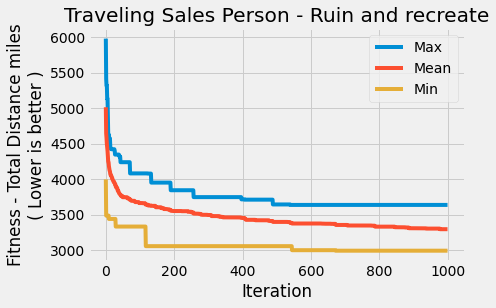

---------- Best Route ----------
Bangor => Leeds => Liverpool => Norwich => Cambridge => Oxford => Manchester => Newcastle => Inverness => Glasgow => Aberdeen => Edinburgh => Brighton => Southampton => Birmingham => Bristol => Swansea => London => Cardiff => Plymouth
---------- Routes total distance ----------
2992.90


In [14]:
plot_graph(ruin_and_recreate_fitness, "Ruin and recreate")
print_best_route(ruin_archive)

# Ruin and recreate
This solutions uses a random permutation of the cities list for each iteration

The beinifits of this is that it will not get stuck at a local minimum and will always find the global minima *eventually*

This approach is best only IF the absolute best solution in required. Although, as the length of inputs increases this number will be so large no computer could compute it, even given the whole life of the universe to try

Ruin and recreate is just a brute force implementation hiding behind an AI facade.

As ruin and recreate uses a random permutation, there is no garantee that by N iterations, it will have covered all the search space (where N is the total number of permutations)

For smaller solutions again this would be better as it will find the global minima, but for larger solutions, the search space is L factorial (where L is the length of the input). It quickly becomes impossible to brute force a solution


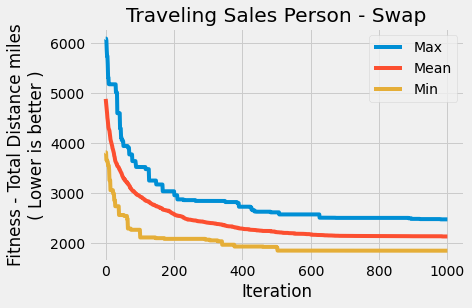

---------- Best Route ----------
Newcastle => Leeds => Liverpool => Bangor => Swansea => Cardiff => Bristol => Plymouth => Southampton => Brighton => Norwich => Cambridge => London => Oxford => Birmingham => Manchester => Glasgow => Edinburgh => Aberdeen => Inverness
---------- Routes total distance ----------
1847.00


In [15]:
plot_graph(swap_fitness, "Swap")
print_best_route(swap_archive)

# Swap
This solution will randomly swap the position of two cities in the route.

This soluition will almost always get stuck in a local minima, this happens when all the single swaps give a worse score, so the hill climber has no where left to go.

However, the local minima that is reached is almost always reached faster and is lower than the ruin and recreate.

This solution will be the best solution when there is not unlimited computing time, and a good answer, but not the absolute best is acceptable.

This solution will start to become the best as the input size grows. The amount of possible permutations increases extremely rapidly with each new input, but this solution will keep on giving a good answer in a relatively short amount of time (for 20 inputs, a good answer takes 1ms!)